In [ ]:
! mkdir -p ~/work/human_segmentation/models
! mkdir -p ~/work/human_segmentation/images
! ln -s ~/data/* ~/work/human_segmentation/images


ln: failed to create symbolic link '/root/work/human_segmentation/images/*': File exists


In [1]:
!pip install opencv-python pixellib

In [4]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


In [7]:
import os
import shutil
from google.colab import files

# 이미지 파일을 저장할 목적지 디렉터리 경로
destination_dir = '/root/work/human_segmentation/images'

# 목적지 디렉터리가 없으면 생성
os.makedirs(destination_dir, exist_ok=True)

print(f"'{destination_dir}'로 파일을 업로드합니다.")

# 1. 파일 업로드 실행
uploaded = files.upload()

# 2. 업로드된 파일 이동
for filename in uploaded.keys():
    # 업로드된 파일은 현재 작업 디렉터리에 있음
    source_path = os.path.join(os.getcwd(), filename)

    # 목적지 경로 설정
    destination_path = os.path.join(destination_dir, filename)

    # 파일을 목적지 디렉터리로 이동
    shutil.move(source_path, destination_path)
    print(f'"{filename}" 파일이 "{destination_dir}"로 성공적으로 이동되었습니다.')

# 3. images 디렉터리 파일 목록 확인
print("\nimages 디렉터리 파일 목록:")
!ls -l {destination_dir}


'/root/work/human_segmentation/images'로 파일을 업로드합니다.


Saving sand.png to sand.png
"sand.png" 파일이 "/root/work/human_segmentation/images"로 성공적으로 이동되었습니다.

images 디렉터리 파일 목록:
total 4500
-rw-r--r-- 1 root root 2786301 Oct 22 05:33 cat.png
-rw-r--r-- 1 root root 1817975 Oct 22 05:33 sand.png


원본 고양이 이미지 크기: (1536, 1024, 3)
배경(사막) 이미지 크기: (1024, 1024, 3)


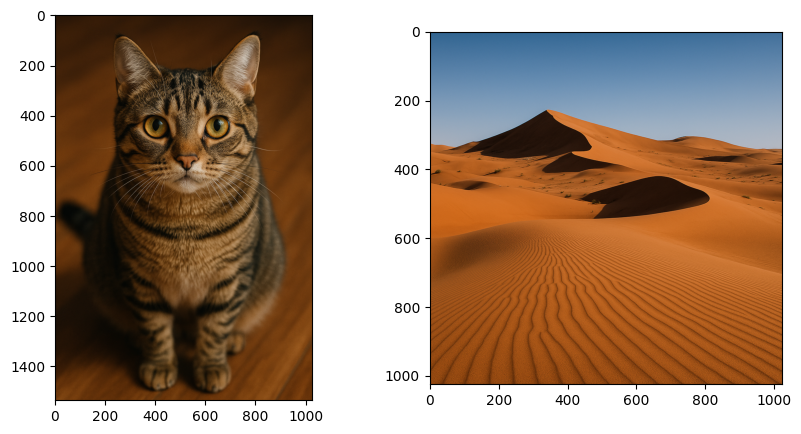

In [9]:
cat_img_path = "/root/work/human_segmentation/images/cat.png"  # 고양이 이미지를 준비해주세요
sand_img_path = "/root/work/human_segmentation/images/sand.png"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [10]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:02<00:00, 103MB/s]


추론 마스크 크기 (Before Resize): (520, 520)


In [11]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (1536, 1024)


In [12]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


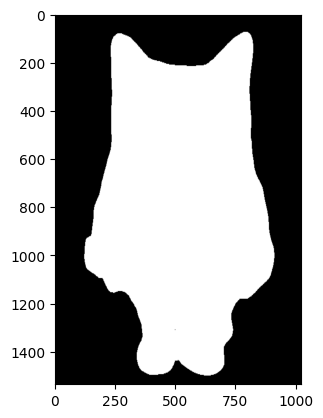

In [13]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

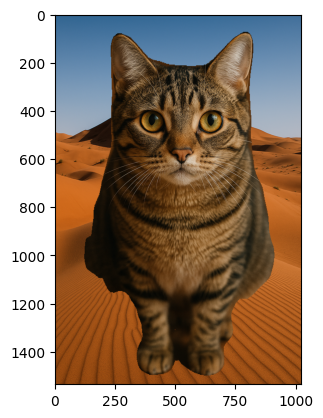

In [14]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

In [65]:
# -*- coding: utf-8 -*-
# Cat on Desert (Step-by-step, clean alpha, top-of-dune placement + soft shadow)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------ 0) 경로 설정 ------------------
cat_img_path  = "/root/work/human_segmentation/images/cat.png"   # 고양이 이미지 (가능하면 배경 투명 PNG)
sand_img_path = "/root/work/human_segmentation/images/sand.png"  # 사막 배경 이미지

# (옵션) 여유 파라미터
CAT_SCALE = 0.17     # 고양이 축소 비율
PLACEX   = 0.52      # 배치 X 위치(배경 너비 대비 비율, 0~1)
PLACEY   = 0.58      # 배치 Y 위치(배경 높이 대비 비율, 0~1)
SHADOW_STRENGTH = 0.35
SHADOW_OFFSET   = (0.06, 0.10)  # (고양이 너비, 높이) 비율로 변환해 그림자 오프셋
ALPHA_ERODE_ITER = 1            # 경계 노이즈 제거(에지 당김)
ALPHA_OPEN_KS    = 3            # 작은 노이즈 제거 (morph open)
ALPHA_BLUR_KS    = 17           # 가장자리 feather (부드럽게)

# ------------------ 유틸 ------------------
def show(img, title="", cmap=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        # RGB 또는 RGBA로 가정 (OpenCV BGR->RGB 변환은 미리 처리)
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def ensure_rgba_from_bgr_or_bgra(img):
    """OpenCV BGR/BGRA 입력을 RGBA/BGRA 두 버전으로 반환."""
    if img.shape[2] == 4:
        bgra = img.copy()
        rgba = cv2.cvtColor(bgra, cv2.COLOR_BGRA2RGBA)
    else:
        bgr  = img
        bgra = cv2.cvtColor(bgr, cv2.COLOR_BGR2BGRA)
        rgba = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        rgba = cv2.cvtColor(bgra, cv2.COLOR_BGRA2RGBA)  # RGBA
    return rgba, bgra

def grabcut_alpha(bgr, iters=6):
    """배경 없는 알파가 없을 때, GrabCut으로 피사체 알파 예측."""
    h, w = bgr.shape[:2]
    margin = 0.08
    rect = (int(w*margin), int(h*margin),
            int(w*(1-2*margin)), int(h*(1-2*margin)))
    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    cv2.grabCut(bgr, mask, rect, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_RECT)
    alpha = np.where((mask==cv2.GC_FGD)|(mask==cv2.GC_PR_FGD), 255, 0).astype(np.uint8)
    return alpha

def clean_alpha(alpha, erode_iter=1, open_ks=3, blur_ks=17):
    """경계 노이즈 제거 + feather로 가장자리 부드럽게."""
    a = alpha.copy()
    if open_ks > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        a = cv2.morphologyEx(a, cv2.MORPH_OPEN, k, iterations=1)
    if erode_iter > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        a  = cv2.erode(a, k2, iterations=erode_iter)
    if blur_ks > 0:
        a  = cv2.GaussianBlur(a, (blur_ks, blur_ks), blur_ks/3)
    return a

def composite_rgba_over_rgb(fg_rgba, bg_rgb, x, y):
    """RGBA 전경을 RGB 배경 위 (x,y)에 알파 합성."""
    H, W, _ = bg_rgb.shape
    h, w = fg_rgba.shape[:2]
    # 캔버스 범위 보정
    x = max(0, min(W - w, int(x)))
    y = max(0, min(H - h, int(y)))

    out = bg_rgb.copy()
    alpha = (fg_rgba[:,:,3] / 255.0)[..., None]
    fg_rgb = fg_rgba[:,:,:3]
    roi = out[y:y+h, x:x+w, :]
    out[y:y+h, x:x+w, :] = (alpha*fg_rgb + (1-alpha)*roi).astype(np.uint8)
    return out

def add_soft_shadow(bg_rgb, alpha_mask, x, y, strength=0.35, blur_ks=41, blur_sigma=18, offset=(20,45)):
    """알파 마스크를 기반으로 그림자 생성 후 배경에 먼저 깔기."""
    H, W, _ = bg_rgb.shape
    h, w = alpha_mask.shape[:2]
    # 오프셋 픽셀로 변환
    if isinstance(offset[0], float):
        sx = int(w*offset[0]); sy = int(h*offset[1])
    else:
        sx, sy = offset

    shadow = (alpha_mask * 0.8).astype(np.uint8)
    shadow = cv2.GaussianBlur(shadow, (blur_ks, blur_ks), blur_sigma)

    ys1 = max(0, y+sy); ys2 = min(H, y+sy+h)
    xs1 = max(0, x+sx); xs2 = min(W, x+sx+w)

    sh_y1 = max(0, 0 - (y+sy))
    sh_x1 = max(0, 0 - (x+sx))
    sh_crop = shadow[sh_y1:sh_y1+(ys2-ys1), sh_x1:sh_x1+(xs2-xs1)]

    out = bg_rgb.copy()
    roi = out[ys1:ys2, xs1:xs2, :]
    sh_f = (sh_crop/255.0)[..., None]
    out[ys1:ys2, xs1:xs2, :] = (roi * (1 - strength*sh_f)).astype(np.uint8)
    return out


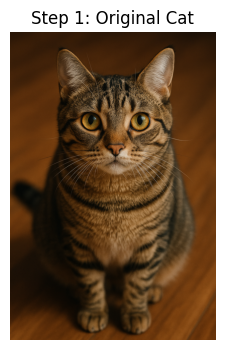

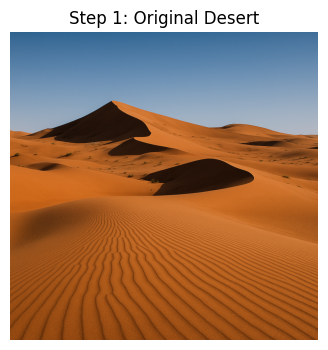

In [66]:

# ------------------ 1) 이미지 로드 ------------------
cat_raw  = cv2.imread(cat_img_path,  cv2.IMREAD_UNCHANGED)  # 3ch(BGR) 또는 4ch(BGRA)
sand_bgr = cv2.imread(sand_img_path, cv2.IMREAD_COLOR)
if cat_raw is None:
    raise FileNotFoundError(f"Cat image not found: {cat_img_path}")
if sand_bgr is None:
    raise FileNotFoundError(f"Sand image not found: {sand_img_path}")

sand_rgb = cv2.cvtColor(sand_bgr, cv2.COLOR_BGR2RGB)
cat_rgba_disp, cat_bgra = ensure_rgba_from_bgr_or_bgra(cat_raw)

show(cat_rgba_disp, "Step 1: Original Cat")
show(sand_rgb,      "Step 1: Original Desert")

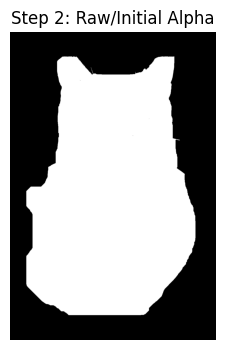

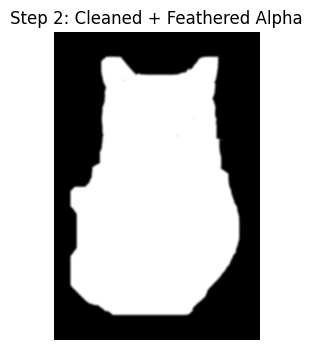

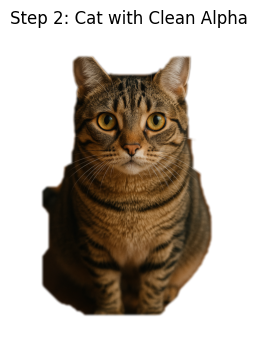

In [67]:

# ------------------ 2) 알파 생성/정제 ------------------
# 고양이에 유효한 알파가 있으면 정제, 없으면 GrabCut으로 생성
if cat_bgra.shape[2] == 4 and np.any(cat_bgra[:,:,3] > 0) and np.any(cat_bgra[:,:,3] < 255):
    alpha_raw = cat_bgra[:,:,3]
else:

    alpha_raw = grabcut_alpha(cv2.cvtColor(cat_bgra, cv2.COLOR_BGRA2BGR), iters=6)

show(alpha_raw, "Step 2: Raw/Initial Alpha", cmap="gray")

alpha_clean = clean_alpha(alpha_raw,
                          erode_iter=ALPHA_ERODE_ITER,
                          open_ks=ALPHA_OPEN_KS,
                          blur_ks=ALPHA_BLUR_KS)
show(alpha_clean, "Step 2: Cleaned + Feathered Alpha", cmap="gray")

cat_bgra_clean = cat_bgra.copy()
cat_bgra_clean[:,:,3] = alpha_clean
cat_rgba_clean = cv2.cvtColor(cat_bgra_clean, cv2.COLOR_BGRA2RGBA)
show(cat_rgba_clean, "Step 2: Cat with Clean Alpha")


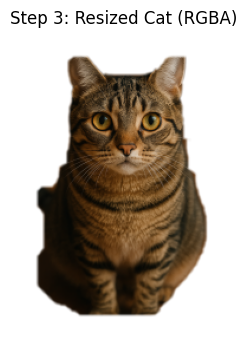

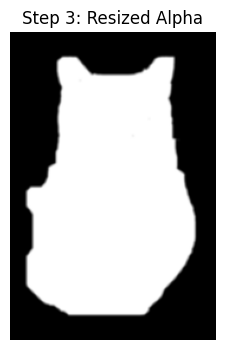

In [68]:

# ------------------ 3) 고양이 축소 ------------------
cat_small_bgra = cv2.resize(cat_bgra_clean, (0,0),
                            fx=CAT_SCALE, fy=CAT_SCALE,
                            interpolation=cv2.INTER_AREA)
cat_small_rgba = cv2.cvtColor(cat_small_bgra, cv2.COLOR_BGRA2RGBA)
show(cat_small_rgba,        "Step 3: Resized Cat (RGBA)")
show(cat_small_bgra[:,:,3], "Step 3: Resized Alpha", cmap="gray")


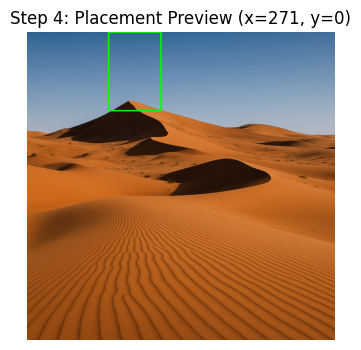

In [72]:

# ------------------ 4) 위치 결정 (모래언덕 꼭대기) ------------------
H, W, _ = sand_rgb.shape
h, w    = cat_small_bgra.shape[:2]

x_offset = int(W*PLACEX - w*1.5)
y_offset = int(H*PLACEY - h*3)

# 범위 보정
x_offset = max(0, min(W - w, x_offset))
y_offset = max(0, min(H - h, y_offset))

preview = sand_rgb.copy()
cv2.rectangle(preview, (x_offset, y_offset), (x_offset+w, y_offset+h), (0,255,0), 3)
show(preview, f"Step 4: Placement Preview (x={x_offset}, y={y_offset})")


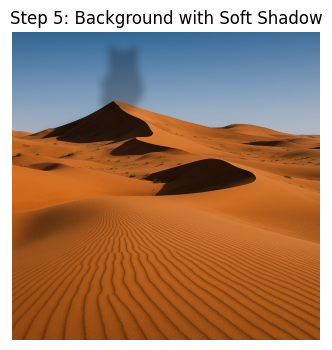

In [86]:

# ------------------ 5) 소프트 그림자 추가 ------------------
shadowed_bg = add_soft_shadow(
    sand_rgb,
    cat_small_bgra[:,:,3],
    x_offset, y_offset,
    strength=SHADOW_STRENGTH,
    blur_ks=41, blur_sigma=15,
    offset=(int(w*SHADOW_OFFSET[0]), int(h*SHADOW_OFFSET[1]))
)
show(shadowed_bg, "Step 5: Background with Soft Shadow")

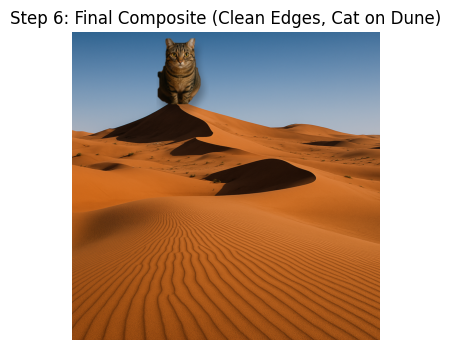

In [87]:

# ------------------ 6) 최종 합성 ------------------
final = composite_rgba_over_rgb(cat_small_rgba, shadowed_bg, x_offset, y_offset)
show(final, "Step 6: Final Composite (Clean Edges, Cat on Dune)")


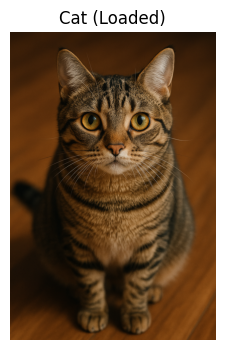

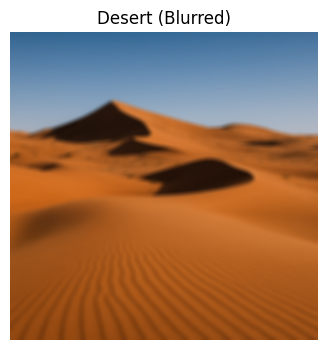

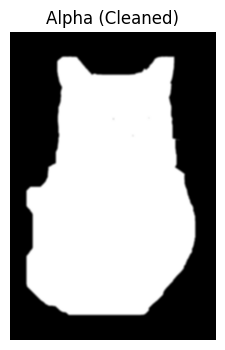

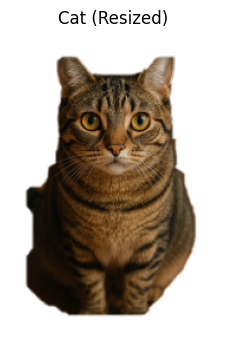

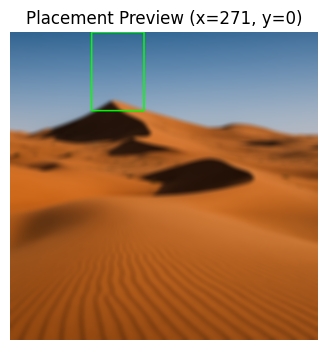

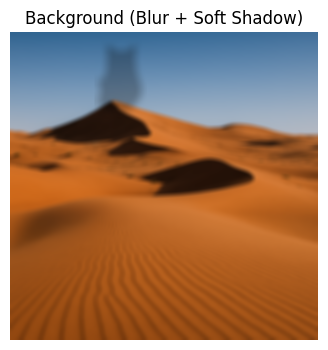

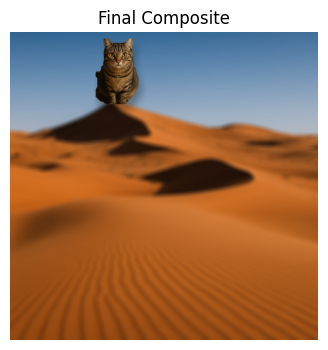

Saved: /mnt/data/cat_on_dune_blur.png


In [89]:
# -*- coding: utf-8 -*-
# Cat on Desert (Simple version + Desert Blur + Soft Shadow)

import cv2, numpy as np, matplotlib.pyplot as plt

# ==== CONFIG ======================================================
cat_img_path  = "/root/work/human_segmentation/images/cat.png"   # 고양이 이미지 (투명 PNG 권장)
sand_img_path = "/root/work/human_segmentation/images/sand.png"  # 사막 배경 이미지

CAT_SCALE = 0.17          # 고양이 축소 비율 (1/5 크기면 0.20)
PLACEX, PLACEY = 0.52, 0.58  # 배치 위치(비율)
SHADOW_STRENGTH = 0.35
SHADOW_OFFSET   = (0.06, 0.10)
BLUR_KERNEL = 21   # 사막 블러 커널(홀수, 클수록 흐림)
BLUR_SIGMA  = 10   # 사막 블러 강도
OUT_PATH = "/mnt/data/cat_on_dune_blur.png"

# ==== COMMON UTILS ===============================================
def show(img, title="", cmap=None, size=(6,4)):
    plt.figure(figsize=size)
    if img.ndim == 2: plt.imshow(img, cmap=cmap or "gray")
    else: plt.imshow(img)
    plt.title(title); plt.axis("off"); plt.show()

def ensure_bgra(img):
    return img if img.shape[2]==4 else cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

def quick_alpha(bgra):
    """이미 알파 있으면 사용, 없으면 GrabCut으로 생성"""
    if bgra.shape[2]==4 and (bgra[:,:,3].max()>0 and bgra[:,:,3].min()<255):
        return bgra[:,:,3]
    bgr = cv2.cvtColor(bgra, cv2.COLOR_BGRA2BGR)
    h,w = bgr.shape[:2]; m = 0.08
    rect = (int(w*m), int(h*m), int(w*(1-2*m)), int(h*(1-2*m)))
    mask = np.zeros((h,w), np.uint8)
    bgd, fgd = np.zeros((1,65),np.float64), np.zeros((1,65),np.float64)
    cv2.grabCut(bgr, mask, rect, bgd, fgd, 5, cv2.GC_INIT_WITH_RECT)
    return np.where((mask==cv2.GC_FGD)|(mask==cv2.GC_PR_FGD),255,0).astype(np.uint8)

def clean_edges(alpha, erode=1, open_ks=3, blur_ks=15):
    a = alpha
    if open_ks>0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(open_ks,open_ks))
        a = cv2.morphologyEx(a, cv2.MORPH_OPEN, k, 1)
    if erode>0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        a  = cv2.erode(a, k2, erode)
    if blur_ks>0:
        a  = cv2.GaussianBlur(a,(blur_ks,blur_ks), blur_ks/3)
    return a

def place_xy(bg, fg, px, py):
    H,W = bg.shape[:2]; h,w = fg.shape[:2]
    x = max(0, min(W-w, int(W*px - w*1.5)))
    y = max(0, min(H-h, int(H*py - h*3)))

    return x,y

def add_shadow(bg_rgb, alpha, x, y, strength=0.35, offset=(0.06,0.10)):
    H,W = bg_rgb.shape[:2]; h,w = alpha.shape[:2]
    sx,sy = int(w*offset[0]), int(h*offset[1])
    sh = cv2.GaussianBlur((alpha*0.8).astype(np.uint8), (41,41), 18)
    ys1, ys2 = max(0,y+sy), min(H,y+sy+h)
    xs1, xs2 = max(0,x+sx), min(W,x+sx+w)
    sh_y1, sh_x1 = max(0,0-(y+sy)), max(0,0-(x+sx))
    sh = sh[sh_y1:sh_y1+(ys2-ys1), sh_x1:sh_x1+(xs2-xs1)]
    out = bg_rgb.copy()
    roi = out[ys1:ys2, xs1:xs2]
    out[ys1:ys2, xs1:xs2] = (roi * (1-(strength*(sh/255.0)[...,None]))).astype(np.uint8)
    return out

def alpha_composite(fg_rgba, bg_rgb, x, y):
    H,W,_ = bg_rgb.shape; h,w = fg_rgba.shape[:2]
    x = max(0, min(W-w, x)); y = max(0, min(H-h, y))
    out = bg_rgb.copy()
    a = (fg_rgba[:,:,3]/255.0)[...,None]
    roi = out[y:y+h, x:x+w]
    out[y:y+h, x:x+w] = (a*fg_rgba[:,:,:3] + (1-a)*roi).astype(np.uint8)
    return out

# ==== MAIN =======================================================
# 1️⃣ Load images
cat  = cv2.imread(cat_img_path,  cv2.IMREAD_UNCHANGED)
sand = cv2.imread(sand_img_path, cv2.IMREAD_COLOR)
if cat is None:  raise FileNotFoundError(cat_img_path)
if sand is None: raise FileNotFoundError(sand_img_path)

# 사막: RGB + Blur
sand_rgb = cv2.cvtColor(sand, cv2.COLOR_BGR2RGB)
sand_rgb = cv2.GaussianBlur(sand_rgb, (BLUR_KERNEL, BLUR_KERNEL), BLUR_SIGMA)
cat_bgra = ensure_bgra(cat)

show(cv2.cvtColor(cat_bgra, cv2.COLOR_BGRA2RGBA), "Cat (Loaded)")
show(sand_rgb, "Desert (Blurred)")

# 2️⃣ Clean alpha
alpha = clean_edges(quick_alpha(cat_bgra))
cat_bgra[:,:,3] = alpha
show(alpha, "Alpha (Cleaned)", cmap="gray")

# 3️⃣ Resize
cat_small = cv2.resize(cat_bgra, (0,0), fx=CAT_SCALE, fy=CAT_SCALE, interpolation=cv2.INTER_AREA)
show(cv2.cvtColor(cat_small, cv2.COLOR_BGRA2RGBA), "Cat (Resized)")

# 4️⃣ Placement
x,y = place_xy(sand_rgb, cat_small, PLACEX, PLACEY)
preview = sand_rgb.copy(); cv2.rectangle(preview,(x,y),(x+cat_small.shape[1],y+cat_small.shape[0]),(0,255,0),3)
show(preview, f"Placement Preview (x={x}, y={y})")

# 5️⃣ Shadow + 6️⃣ Composite
bg_shadow = add_shadow(sand_rgb, cat_small[:,:,3], x, y, strength=SHADOW_STRENGTH, offset=SHADOW_OFFSET)
final     = alpha_composite(cv2.cvtColor(cat_small, cv2.COLOR_BGRA2RGBA), bg_shadow, x, y)

show(bg_shadow, "Background (Blur + Soft Shadow)")
show(final, "Final Composite")

# 7️⃣ Save
cv2.imwrite(OUT_PATH, cv2.cvtColor(final, cv2.COLOR_RGB2BGR))
print("Saved:", OUT_PATH)
